In [61]:
import os, sys
from IPython.display import Image
import pandas as pd
from __future__ import division
import numpy as np
import rpy2
from rpy2 import robjects as ro
import pandas.rpy.common as com
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import scipy as sp
import traceback
from sklearn import preprocessing
from IPython.parallel import Client
from subprocess import Popen, PIPE
import shutil
from IPython.display import FileLink, FileLinks, Image
import psutil
import multiprocessing
from hdfstorehelper import HDFStoreHelper
import warnings
import pandas
import dill
warnings.simplefilter("ignore", pandas.io.pytables.PerformanceWarning)
%matplotlib inline

%load_ext rpy2.ipython
pd.set_option('display.width', 80)
pd.set_option('max.columns', 30)

sns.set_context("talk")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [65]:
traits = [x for x in pheno.columns if "ose" in str(x)]
print traits
trait_name = traits[-1]
dill.dump(trait_name, open("cfried_trait_name.dill", "w"))

[u'melezitose']


In [12]:
pheno = pd.read_excel("/gdc_home4/cfried/landscape_genetics_data/Pinus_taeda_metabolite_data.xlsx", 
                      sheetname="metabolite_phenotype_data",
                      header=2)
pheno = pheno[['Longitude', 'Latitude','Clone_id',trait_name]]
pheno.index = pheno.Clone_id
pheno = pheno.drop('Clone_id', axis=1)
pheno = pheno.astype(float)

In [13]:
data_ai = pd.read_excel("/gdc_home4/cfried/landscape_genetics_data/Genetics_2010/Eckert_Genetics_2010_data.xlsx")
data_gt = pd.read_excel("/gdc_home4/cfried/landscape_genetics_data/Genetics_2010/Eckert_Genetics_2010_data.xlsx", 
                        sheetname="genotyping_data")
data_loc = pd.read_excel("/gdc_home4/cfried/landscape_genetics_data/Genetics_2010/Eckert_Genetics_2010_data.xlsx",
                         sheetname="county_locality")

In [19]:
def add_county_state_key(df, c, s):
    d = df.copy()
    d['county_state'] = d.apply(lambda row: "%s_%s" % (row[c], row[s]), axis=1)
    return d

In [22]:
data_ai = add_county_state_key(data_ai, "County", "State")
data_ai.ix[:,0:2] = data_ai.ix[:,0:2].astype(str)
data_ai.ix[:,2:-1] = data_ai.ix[:,2:-1].astype(float)
data_ai.head()

,County,State,AI_Q1,AI_Q2,AI_Q3,AI_Q4,county_state
0,AIKEN,SC,5.310381,0.941023,0.774065,2.175380,AIKEN_SC
1,ANDERSON,SC,7.833872,1.034978,0.754804,2.920798,ANDERSON_SC
2,ANSON,NC,5.763893,0.889168,0.818064,2.488546,ANSON_NC
3,APPOMATTOX,VA,4.582158,0.840920,0.673995,2.740322,APPOMATTOX_VA
4,ASHLEY,AR,6.927071,1.191490,0.671492,3.429608,ASHLEY_AR


In [23]:
data_loc = add_county_state_key(data_loc, "county", "state")
data_loc.ix[:,0:2] = data_loc.ix[:,0:2].astype(str)
data_loc.ix[:,2:-1] = data_loc.ix[:,2:-1].astype(float)
data_loc.head()

,county,state,lat,long,county_state
0,CHEROKEE,GA,34.24000,-84.47000,CHEROKEE_GA
1,BARTOW,GA,34.24000,-84.84000,BARTOW_GA
2,SUSSEX,VA,36.92093,-77.28034,SUSSEX_VA
3,KING & QUEEN,VA,37.66986,-76.87746,KING & QUEEN_VA
4,KING & QUEEN,VA,37.66986,-76.87746,KING & QUEEN_VA


In [24]:
data_gt = data_gt.astype(str)
data_gt = add_county_state_key(data_gt, "county", "state")
data_gt.head()

,county,state,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,0-10113-01-119,0-10116-01-165,0-10151-01-86,0-10162-01-255,...,4033_01,4033_02,4056_01,4056_02,4058_01,4058_02,4093_01,4093_02,4112_01,4112_02,4137_01,4137_02,4181_01,4181_0,county_state
0,CHEROKEE,GA,G/G,A/C,G/G,A/A,G/G,A/G,A/A,G/G,A/C,A/A,A/A,A/A,A/A,...,131,143,413,413,143,150,307,310,462,462,161,161,365,390,CHEROKEE_GA
1,BARTOW,GA,A/A,C/C,G/G,A/A,G/G,A/G,A/A,A/G,A/A,G/G,A/A,A/A,A/A,...,?,?,413,437,137,143,307,307,440,448,161,176,365,365,BARTOW_GA
2,SUSSEX,VA,A/A,C/C,C/C,G/G,G/G,A/G,A/A,G/G,A/A,A/G,A/A,A/A,A/G,...,133,133,413,413,150,152,322,325,462,462,161,169,378,395,SUSSEX_VA
3,KING & QUEEN,VA,A/A,A/A,C/C,G/G,A/G,G/G,A/A,G/G,A/A,A/G,A/A,A/A,A/A,...,133,152,413,413,146,154,307,325,460,462,163,190,390,417,KING & QUEEN_VA
4,KING & QUEEN,VA,A/A,A/C,C/C,?/?,G/G,A/G,A/A,G/G,A/A,A/A,A/A,A/A,?/?,...,?,?,413,431,143,146,310,322,462,462,169,169,395,409,KING & QUEEN_VA


In [38]:
hdf = HDFStoreHelper("cfried.hd5") ##change this to your username!

In [39]:
hdf.put("pheno", pheno)

updating pheno


In [40]:
hdf.put("data_ai", data_ai)

updating data_ai


In [41]:
hdf.put("data_loc", data_loc)

updating data_loc


In [42]:
hdf.put("data_gt", data_gt)

updating data_gt


In [43]:
genotypes = data_gt.ix[:,[x for x in data_gt.columns if '-' in x]]

In [44]:
hdf.put("genotypes", genotypes)

In [57]:
def is_homozygous(gt):
    if len(set([x.strip() for x in gt.split("/")])) == 1:
        return True
    return False

def get_allele_counts(counts):
    a = {}
    het = 0
    for gt in counts.index:
        for allele in [x.strip() for x in gt.split("/")]:
            if not allele in a:
                a[allele] = 0
            a[allele] += counts[gt]
        if not is_homozygous(gt):
            het += counts[gt]
    return sorted(a.items(), key=lambda x: x[1], reverse=True), het

def get_correction(n):
    #for finite sample size
    return (2*n)/(2*n-1)

def get_allele_freqs(locus):
    locus = locus[locus != '?/?']
    locus = locus[locus != 'NA']
    c = locus.value_counts()
    c = c.sort(inplace=False, ascending=False)
    allele_counts = get_allele_counts(c)
    total_alleles = 2.0*sum(c)
    num_individuals = sum(c)
    A = ""
    a = ""
    P = 0
    Q = 0
    if len(allele_counts[0]) == 2:
        A = allele_counts[0][0][0]
        a = allele_counts[0][1][0]
        P = allele_counts[0][0][1]
        Q = allele_counts[0][1][1]
    else:
        A = allele_counts[0][0][0]
        P = P = allele_counts[0][0][1]
    PQ = allele_counts[-1]
    p = P/total_alleles
    q = Q/total_alleles
    assert p + q == 1.0
    He = 2 * p * q * get_correction(num_individuals)
    Ho = PQ*1.0/num_individuals
    Fis = 1 - (Ho/He)
    #print p, q, He, Ho, Fis
    ret = pd.Series({"p":p, 
                      "q":q,
                      "P":P,
                      "Q":Q,
                      "He":He,
                      "Ho":Ho, 
                      "Fis":Fis,
                    "PQ": PQ,
                    "total_alleles":total_alleles,
                    "num_indiv":num_individuals,
                    "A":A,
                    "a":a})
    return ret

def plot_hist(df, index):
    d = df.ix[index,:]
    plt.hist(d, bins=20)
    plt.title("%s %.2f $\pm$ %.3f [%.2f, %.2f]" % (index, 
                                                   np.mean(d), 
                                                   np.std(d),
                                                  np.min(d),
                                                  np.max(d)))
    
def convert_to_z12(locus):
    freq = af[locus.name]
    trans = {"%s/%s" % (freq["A"],freq["A"]): 0,
            "%s/%s" % (freq["a"],freq["a"]): 2,
            "%s/%s" % (freq["A"],freq["a"]): 1,
            "%s/%s" % (freq["a"],freq["A"]): 1,
            "?/?":-1}
    return locus.apply(lambda x: trans[x])

def center_and_standardize_value(val, u, var):
    if val == -1:
        return 0.0
    return (val-u)/np.sqrt(var)

def center_and_standardize(snp):
    maf = af.ix["q",snp.name]
    u = np.mean([x for x in snp if x != -1])
    var = np.sqrt(maf*(1-maf))
    return snp.apply(center_and_standardize_value, args=(u, var))

In [46]:
af = genotypes.apply(get_allele_freqs)

In [51]:
hdf.put("af", af)

updating af


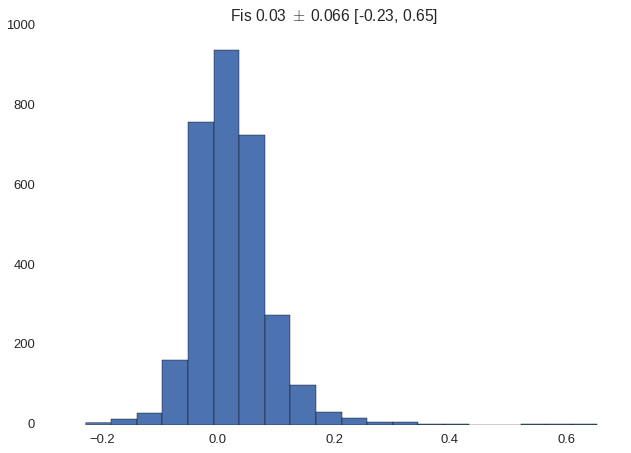

In [53]:
plot_hist(af, "Fis")

In [55]:
z12 = genotypes.apply(convert_to_z12)

In [56]:
hdf.put("z12", z12)

In [58]:
pca_std = z12.apply(center_and_standardize)

In [59]:
hdf.put("pca_std", pca_std)